***Paul M. Washburn and Asher Diamante***

# About the Data

## Overview

All data is at the daily level, represented as a volume weighted average.  Although data was available prior to 2017 for most traditional economic indicators, the same was not true for many cryptocurrencies (as many did not yet exist).  Further complicating things, the crypto market has been through wild fluctuations in both 2017 and 2018, making prior periods look tame and un-representative of the change about to come (likely due to low volume of early adopters).  For these reasons only data from 2017 forward was used for this analysis.

The sections below will constitute a data dictionary for the columns utilized in this inquiry.

## Cryptocurrencies

The data we chose to use for this project includes various time-series vectors that summarize the market value of different financial instruments, index values and commodity prices.  Of particular focus are a bag of cryptocurrencies that we believe are representative of the crypto market in general.

The cryptocurrencies included in this analysis are:

- BTC: [Bitcoin](https://bitcoin.org/en/), the first P2P digital currency by far the most valuable coin on the market
- ETH: [Ethereum](https://www.ethereum.org/), a blockchain app platform for smart applications/contracts
- ETCL [Ethereum Classic](https://ethereumclassic.github.io/), focusing on fraud and smart contracts
- DASH: [Dash](https://www.dash.org/), a coin focused on creating a digital money system
- SC: [Siacoin](https://sia.tech/), a decentralized storage platform (cloud) focused on under-utilized capacity
- GNT: [Golem](https://golem.network/), a coin focused on under-utilized computing infrastructure for elastic computing
- LTC: [Litecoin](https://litecoin.org/), a P2P digital currency focused on speed of transactions relative to BTC
- STR: [Stellar](https://www.stellar.org/), a coin focused on transforming the banking industry
- XEM: [NEM](https://nem.io/), a coin focused on asset tracking via blockchain
- XMR: [Monero](https://getmonero.org/), a digital currency focused on privacy
- XRP: [Ripple](https://ripple.com/xrp/), a digital asset focused on fast global payments

## US Equity Indices

Given the importance of equity markets to the health of the overall economy, as well as the media's obsession with their movements, daily time-series of the following were included:

- SP500: [SPX S&P 500 Index](https://us.spindices.com/indices/equity/sp-500) of large-cap US equities
- NASDAQCOM: [Nasdaq Composite Index](http://money.cnn.com/data/markets/nasdaq/) of large-cap US equities
- DJIA: [Dow Jones Industrial Average](https://quotes.wsj.com/index/DJIA) of US equities
- RU2000PR: [Russell 2000 Price Index](https://fred.stlouisfed.org/series/RU2000PR) of US equities

The `pandas_datareader.data` and `quandl` APIs were used to acquire this information.

## Traditional Currencies

The [St. Louis Federal Reserve's FRED API](https://fred.stlouisfed.org/) was accessed using the `pandas_datareader.data` API to gather currency exchange rates of the US Dollar against the Japanese Yen, the Euro, the Chinese Yuan, the Mexican Peso, and the Australian Dollar.

- DEXCHUS: [Chinese Yuan to USD](https://fred.stlouisfed.org/series/DEXCHUS)
- DEXJPUS: [Japanese Yen to USD](https://fred.stlouisfed.org/series/DEXJPUS)
- DEXUSEU: [USD to European Union's Euro](https://fred.stlouisfed.org/series/DEXUSEU)
- DEXMXUS: [Mexican New Pesos to USD](https://fred.stlouisfed.org/series/DEXMXUS)
- DEXUSAL: [USD to Australian Dollar](https://fred.stlouisfed.org/series/DEXUSAL)

To stay consistent, the Euro exchange rate and the Peso exchange rate are inverted to be in terms of USD like the others.  

## Debt Market Indicators

A ladder of bond market indicators are represented in the data in LIBOR rates at various maturities.  Specifically, LIBOR is included at overnight, 1-month, 3-month and 12-month maturities.  To (very crudely) represent the consumer and the corporate markets we also included indices representing high yield returns and prime corporate debt returns.

- USDONTD156N: [Overnight London Interbank Offered Rate (LIBOR)](https://fred.stlouisfed.org/series/USDONTD156N) based on USD
- USD1MTD156N: [One Month London Interbank Offered Rate (LIBOR)](https://fred.stlouisfed.org/series/USD1MTD156N) based on USD
- USD3MTD156N: [Three Month London Interbank Offered Rate (LIBOR)](https://fred.stlouisfed.org/series/USD3MTD156N) based on USD
- USD12MD156N: [Twelve Month London Interbank Offered Rate (LIBOR)](https://fred.stlouisfed.org/series/USD12MD156N) based on USD
- BAMLHYH0A0HYM2TRIV: [ICE BofAML US High Yield Total Return Index Value](https://fred.stlouisfed.org/series/BAMLHYH0A0HYM2TRIV)
- BAMLCC0A1AAATRIV: [ICE BofAML US Corp AAA Total Return Index Value](https://fred.stlouisfed.org/series/BAMLCC0A1AAATRIV)

These series were also acquired from the St. Louis Fed's FRED API.

## Commodity Prices

We chose to include series that represent the oil market and the gold market, two assets that are not strongly tied to the others mentioned.

- GOLDAMGBD228NLBM: [Gold Fixing Price 10:30 AM (London Time) in London Bullion Market, based on  USD](https://fred.stlouisfed.org/series/GOLDAMGBD228NLBM)
- DCOILWTICO: [West Texas Intermediate (WTI) - Cushing Oklahoma](https://fred.stlouisfed.org/series/DCOILWTICO)

These series were also acquired from the St. Louis Fed's FRED API.

# Exploratory Analysis

## Methodology for Exploring Data

- Check for missing data and impute missing values and/or drop columns that are incomplete
- Characterize scale differences in the series to highlight the need for scaling
- Create a scaled version of the dataset using a standard scaler and a min-max scaler
- Enrich data with holidays and days of week to investigate whether there are any temporal patterns
- Generate a pairplots to visualize relationships between the scaled vectors
- Generate correlation matrices of (1) the series themselves and (2) the percent changes in non-scaled data

## Data Cleaning & Reconciliation

In [79]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import seaborn as sns

pd.set_option('max_columns', 999)
pd.set_option('max_rows', 99999)

%matplotlib inline

In [67]:
def generate_calendar(year):
    '''
    Simple function to generate a calendar containing
    US holidays, weekdays and  holiday weeks.
    '''
    from pandas.tseries.offsets import YearEnd
    from pandas.tseries.holiday import USFederalHolidayCalendar
    
    start_date = pd.to_datetime('1/1/'+str(year))
    end_date = start_date + YearEnd()
    DAT = pd.date_range(str(start_date), str(end_date), freq='D')
    MO = [d.strftime('%B') for d in DAT]
    holidays = USFederalHolidayCalendar().holidays(start=start_date, end=end_date)

    cal_df = pd.DataFrame({'date':DAT, 'month':MO})
    cal_df['year'] = [format(d, '%Y') for d in DAT]
    cal_df['weekday'] = [format(d, '%A') for d in DAT]
    cal_df['is_weekday'] = cal_df.weekday.isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])
    cal_df['is_weekday'] = cal_df['is_weekday'].astype(int)
    cal_df['is_holiday'] = cal_df['date'].isin(holidays)
    cal_df['is_holiday'] = cal_df['is_holiday'].astype(int)
    cal_df['is_holiday_week'] = cal_df.is_holiday.rolling(window=7,center=True,min_periods=1).sum()
    cal_df['is_holiday_week'] = cal_df['is_holiday_week'].astype(int)
    
    cal_df.set_index('date', inplace=True)
    
    return cal_df

In [2]:
base_dir = 'C:/Users/pmwash/Desktop/Harvard/CS109b/Project/'
df_eda = pd.read_csv(base_dir + 'project_data_2017_2018.csv')

### Checking for Missing Data

Below we count the number of missing values for each column in the 2017-2018 dataset.  It is shown that `GNT`, or Golem, is missing 48 of 422 expected observations due to the fact that it was not actively traded at the beginning of this time period.  Given that ICOs (initial coin offerings) take a while to coordinate, missing values for `GNT` are imputed using backfill.

In [32]:
count_missing = lambda df, col: {'col': col, 'missing': df[col].isnull().sum(), 'n_obs': df[col].count()}
missing_by_col = [count_missing(df_eda, col) for col in df_eda.columns]
pd.DataFrame(missing_by_col).set_index('col')

,missing,n_obs
col,,
date,0,422
DASH,0,422
ETC,0,422
ETH,0,422
GNT,48,374
LTC,0,422
SC,0,422
STR,0,422
XEM,0,422


In [33]:
df_eda['GNT'] = df_eda['GNT'].fillna(method='bfill')
count_missing(df_eda, 'GNT')

{'col': 'GNT', 'missing': 0, 'n_obs': 422}

### Scale Data & Save Separate Version

Below we demonstrate that there are huge differences in both the scale between the columns as well as the distributions.  As is expected from the blockbuster year that many cryptos have enjoyed we see that the standard deviation of all cryptos is as large or larger than the mean.  For this reason [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) was used to scale these columns and [`sklearn.preprocessing.StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) was used to process the remainder.  The minimum and maximum of `feature_range` argument of the `MinMaxScaler.fit_transform()` method was set to `(-2, 2)` in order to make the values similar to the ones produced by the `StandardScaler.fit_transform()` method.  This is demonstrated by the second `pd.DataFrame.describe()` call below.

In [37]:
df_eda.describe().T

,count,mean,std,min,25%,50%,75%,max
DASH,422.0,315.965938,315.285763,11.444337,84.196241,192.375086,418.601086,1402.425173
ETC,422.0,14.151520,10.624763,1.172033,2.753551,14.081595,18.568618,43.423449
ETH,422.0,321.980512,316.944518,8.222735,49.387878,279.549049,359.964492,1363.949636
GNT,422.0,0.286022,0.224790,0.019279,0.088333,0.251350,0.365522,1.096991
LTC,422.0,69.161400,78.865807,3.708275,11.486493,45.110966,70.572352,346.905402
SC,422.0,0.009740,0.012355,0.000227,0.000808,0.005229,0.011616,0.064279
STR,422.0,0.094800,0.169957,0.001674,0.003455,0.021282,0.045196,0.785691
XEM,422.0,0.271433,0.333536,0.003243,0.024176,0.198715,0.269310,1.822529
XMR,422.0,105.726554,113.216553,10.440639,21.117876,48.058701,130.075757,425.913240
XRP,422.0,0.353831,0.512178,0.005442,0.033898,0.202699,0.262637,2.958787


In [48]:
non_norm_cols = ['DASH', 'ETC', 'ETH', 'GNT', 'LTC', 'SC', 'STR', 'XEM', 'XMR', 'XRP', 'BTC'] 
mms = MinMaxScaler(feature_range=(-2, 2))
df_eda_scaled = pd.DataFrame(mms.fit_transform(df_eda[non_norm_cols]), 
                             columns=non_norm_cols,
                             index=df_eda['date'])

non_norm_cols = non_norm_cols + ['date']
norm_cols = [col for col in df_eda.columns if col not in non_norm_cols]
std = StandardScaler()
df_eda_scaled[norm_cols] = pd.DataFrame(std.fit_transform(df_eda[norm_cols]), 
                                        columns=norm_cols,
                                        index=df_eda['date'])

df_eda_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
DASH,422.0,-1.124297e+00,0.906657,-2.000000,-1.790790,-1.479703,-0.829152,2.000000
ETC,422.0,-7.712141e-01,1.005861,-2.000000,-1.850276,-0.777834,-0.353041,2.000000
ETH,422.0,-1.074274e+00,0.935128,-2.000000,-1.878544,-1.199466,-0.962205,2.000000
GNT,422.0,-1.009966e+00,0.834323,-2.000000,-1.743701,-1.138653,-0.714897,2.000000
LTC,422.0,-1.237137e+00,0.919190,-2.000000,-1.909344,-1.517447,-1.220692,2.000000
SC,422.0,-1.405915e+00,0.771545,-2.000000,-1.963741,-1.687661,-1.288804,2.000000
STR,422.0,-1.524879e+00,0.867109,-2.000000,-1.990915,-1.899960,-1.777956,2.000000
XEM,422.0,-1.410341e+00,0.733334,-2.000000,-1.953974,-1.570222,-1.415008,2.000000
XMR,422.0,-1.082626e+00,1.090003,-2.000000,-1.897204,-1.637829,-0.848202,2.000000
XRP,422.0,-1.528143e+00,0.693693,-2.000000,-1.961459,-1.732836,-1.651656,2.000000


### Merge Calendar Information

The self-authored function `generate_calendar` generates calendar features for all days in a given `year`.  This function utilizes pandas' `pd.tseries.offsets.YearEnd` and  `pd.tseries.holiday.USFederalHolidayCalendar` classes to get information on US holidays.  

In [68]:
yrz = [2017, 2018]
cal_df = pd.DataFrame()
for yr in yrz:
    cal_df = cal_df.append(generate_calendar(year=yr))

cal_df.head()

,month,year,weekday,is_weekday,is_holiday,is_holiday_week
date,,,,,,
2017-01-01,January,2017,Sunday,0,0,1
2017-01-02,January,2017,Monday,1,1,1
2017-01-03,January,2017,Tuesday,1,0,1
2017-01-04,January,2017,Wednesday,1,0,1
2017-01-05,January,2017,Thursday,1,0,1


In [69]:
df_eda_scaled = df_eda_scaled.join(cal_df)
df_eda_scaled.head()

,DASH,ETC,ETH,GNT,LTC,SC,STR,XEM,XMR,XRP,BTC,SP500,NASDAQCOM,DJIA,RU2000PR,DEXJPUS,DEXUSEU,DEXCHUS,DEXMXUS,DEXUSAL,VIXCLS,USDONTD156N,USD1MTD156N,USD3MTD156N,USD12MD156N,BAMLHYH0A0HYM2TRIV,BAMLCC0A1AAATRIV,GOLDAMGBD228NLBM,DCOILWTICO,month,year,weekday,is_weekday,is_holiday,is_holiday_week
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,-2.000000,-1.975785,-1.999555,-1.921301,-1.991252,-2.000000,-1.995731,-1.999501,-1.969275,-1.998602,-1.956631,-1.689165,-1.941136,-1.388932,-1.175171,2.423049,-1.510373,1.327609,1.745992,-2.456905,0.688917,-1.617390,-1.611099,-1.430451,-0.884209,-2.289847,-1.605246,-2.591862,0.216453,January,2017,Sunday,0,0,1
2017-01-02,-1.999326,-1.977608,-2.000000,-1.921301,-1.989797,-1.999620,-1.996010,-1.999743,-1.953251,-1.998862,-1.950898,-1.689165,-1.941136,-1.388932,-1.175171,2.423049,-1.510373,1.327609,1.745992,-2.456905,0.688917,-1.617390,-1.611099,-1.430451,-0.884209,-2.289847,-1.605246,-2.591862,0.216453,January,2017,Monday,1,1,1
2017-01-03,-1.996616,-1.969486,-1.996865,-1.921301,-1.990180,-1.999517,-1.995869,-1.999533,-1.945859,-1.998746,-1.949335,-1.561126,-1.850400,-1.322245,-1.058547,2.861031,-1.743954,1.408432,2.038396,-2.451701,0.331775,-1.603686,-1.604509,-1.426935,-0.866758,-2.169834,-1.573791,-2.840192,-0.031500,January,2017,Tuesday,1,0,1
2017-01-04,-1.988252,-1.957044,-1.992946,-1.921301,-1.990177,-1.997820,-1.995161,-1.999537,-1.935472,-1.998506,-1.934031,-1.474060,-1.755795,-1.288442,-0.745213,2.715037,-1.640903,1.267409,2.523545,-2.248727,0.031655,-1.624262,-1.635354,-1.399863,-0.866758,-2.006526,-1.525559,-2.430269,0.129045,January,2017,Wednesday,1,0,1
2017-01-05,-1.991918,-1.961096,-1.994650,-1.921301,-1.992550,-1.997886,-1.995881,-1.999884,-1.945725,-1.999425,-1.953132,-1.485853,-1.734197,-1.312434,-0.968638,1.780676,-1.431367,1.015462,2.533157,-1.915643,-0.022367,-1.616937,-1.635354,-1.382197,-0.866758,-1.903984,-1.204716,-2.260359,0.220021,January,2017,Thursday,1,0,1


### Pairplots of Features

Below we investigate the correlations between the scaled features.  Two pairplots are created: one for the cryptocurrencies and one for the more traditional financial assets.  To investigate the existence of a bubble in either market over time, as well as for visual purposes, the `year` is highlighted in both pairplots.

In [74]:
non_norm_cols.pop()
cols_to_plot = non_norm_cols + norm_cols
cols_to_plot

'date'

Text(0.5,0.98,'Cryptocurrency Pairplot - 2017 vs. 2018')

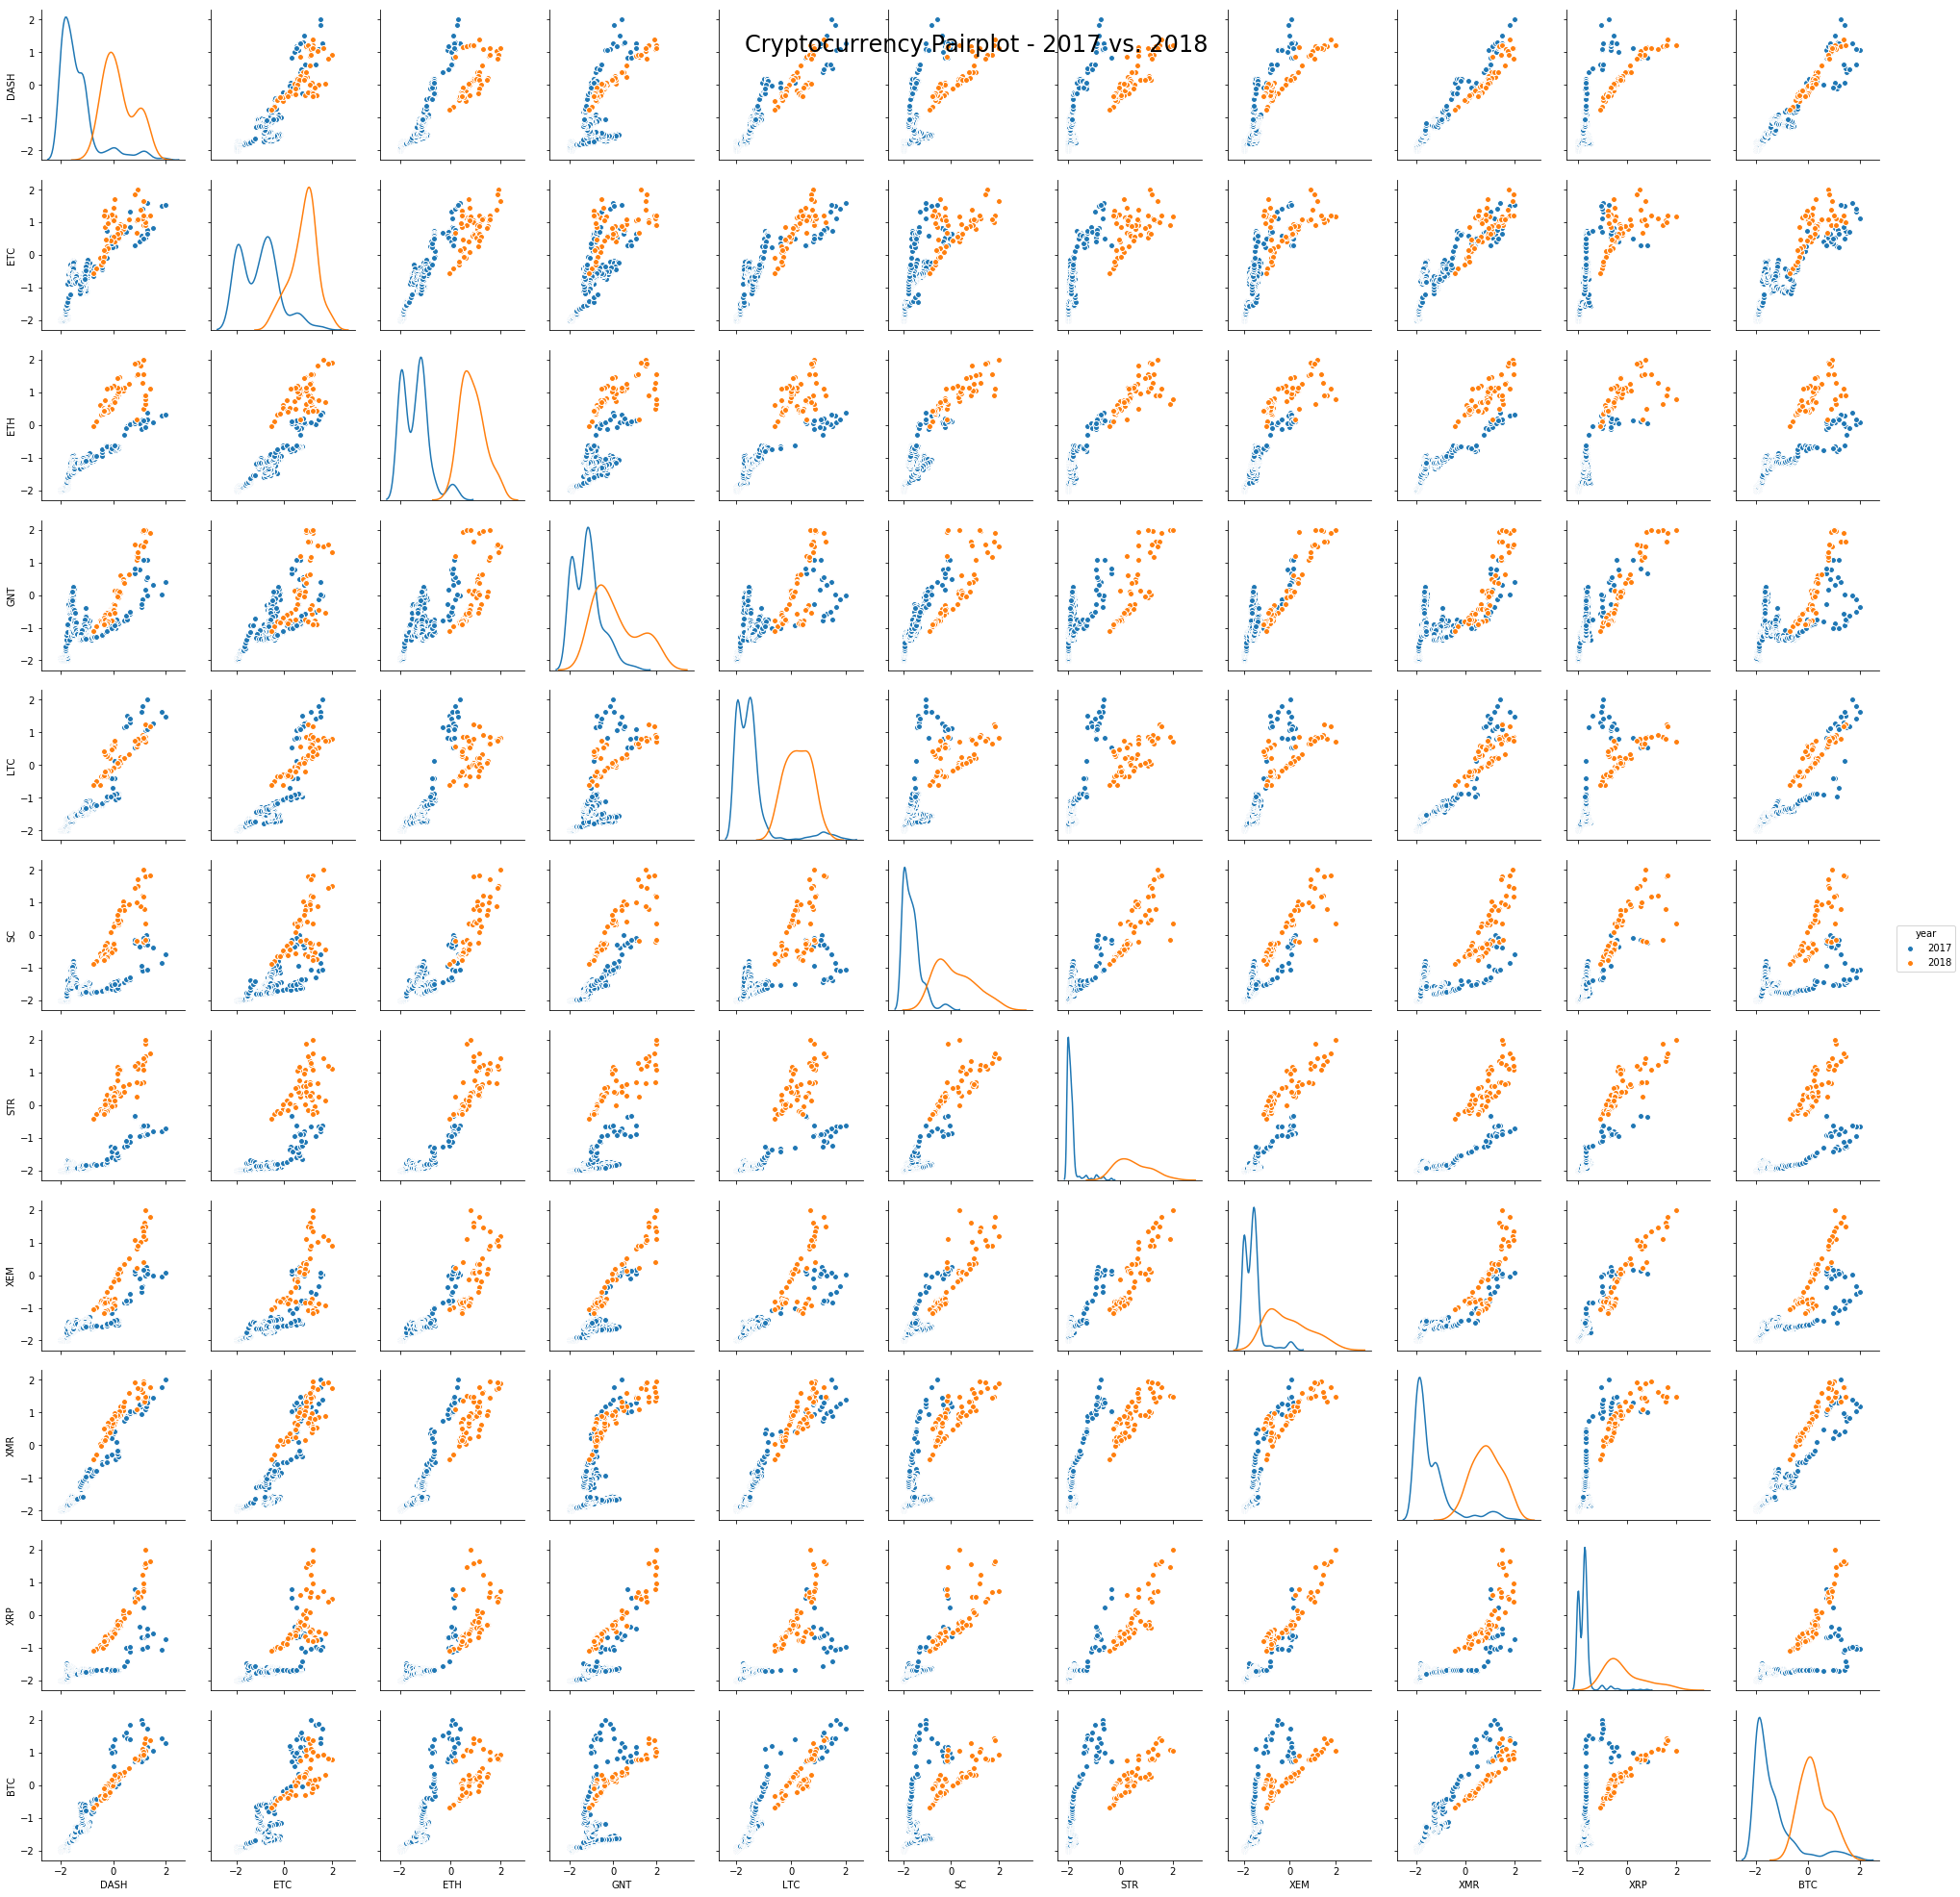

In [91]:
sns.pairplot(df_eda_scaled, vars=non_norm_cols, hue='year', diag_kind='kde')
plt.suptitle('Cryptocurrency Pairplot - 2017 vs. 2018', size=24)

Text(0.5,0.98,'Traditional Financial Indicator Pairplot - 2017 vs. 2018')

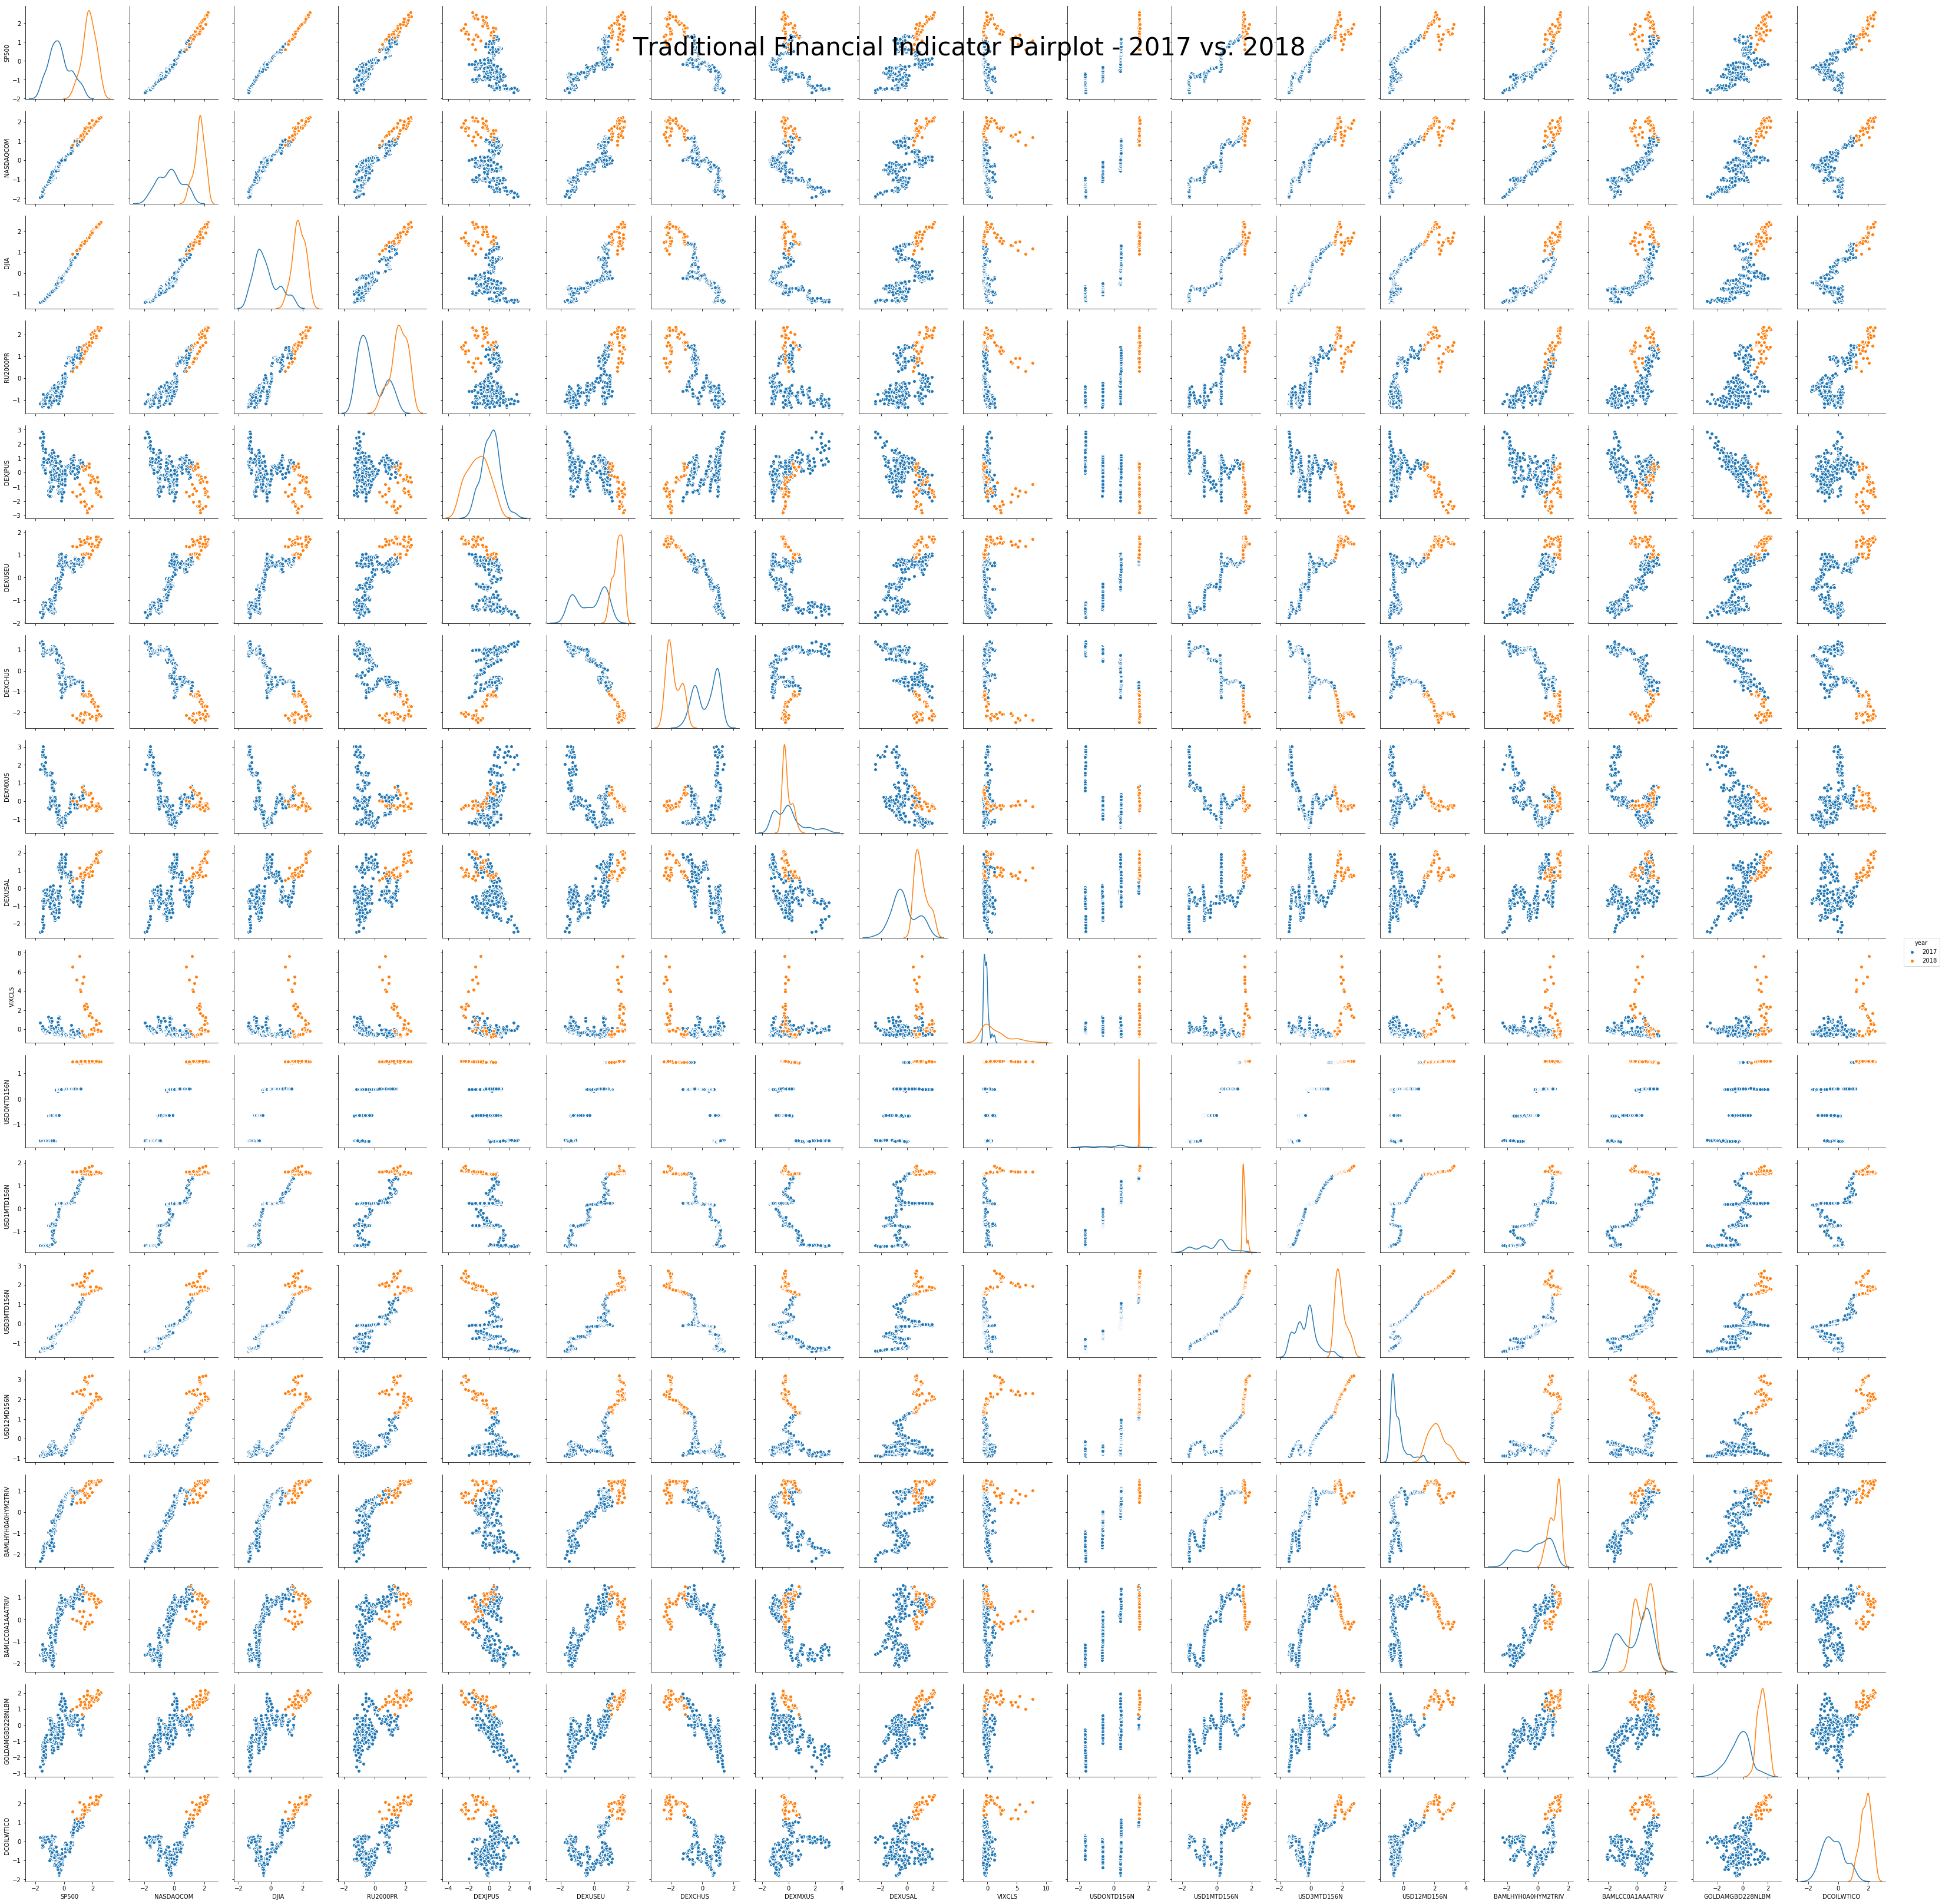

In [93]:
sns.pairplot(df_eda_scaled, vars=norm_cols, hue='year', diag_kind='kde')
plt.suptitle('Traditional Financial Indicator Pairplot - 2017 vs. 2018', size=42)

It is interesting to note that by grouping the data by year (2017 and 2018) we see strong separation in both the scatterplots and the kernel density plots on the diagonals.  This could be indicative of a bubble, but is definitely indicative that the markets have been moving over time.

The cryptocurrency pairlot shows strong positive correlation between the various coins.  This was somewhat expected given the market movements that have transpired this year.  

As was somewhat expected at the outset (based on the shear number of features involved in this analysis) these plots are somewhat difficult to read and interpret.  This was the reason behind using correlation matrices below.  However it is still interesting to note some of the very interesting patterns that exist in the financial datasets -- the scatterplots show a strange non-linearity in some of the pairs.  This may be some complex economic interaction, an effect of scaling the data, or simply some other phenomenon that has not been considered.  This does, however, bring up the problem of collinearity in the $X$ variables.

### Heatmaps of Scaled Data Correlation Matrix at Various Cutoffs

The function `correlation_heatmap` below produces a pearson correlation matrix between the features, sets the diagonal to zero (for visual purposes), then mutes all correlation values that are below a specified `cutoff` argument.  This cutoff is helpful in filtering out the noise.

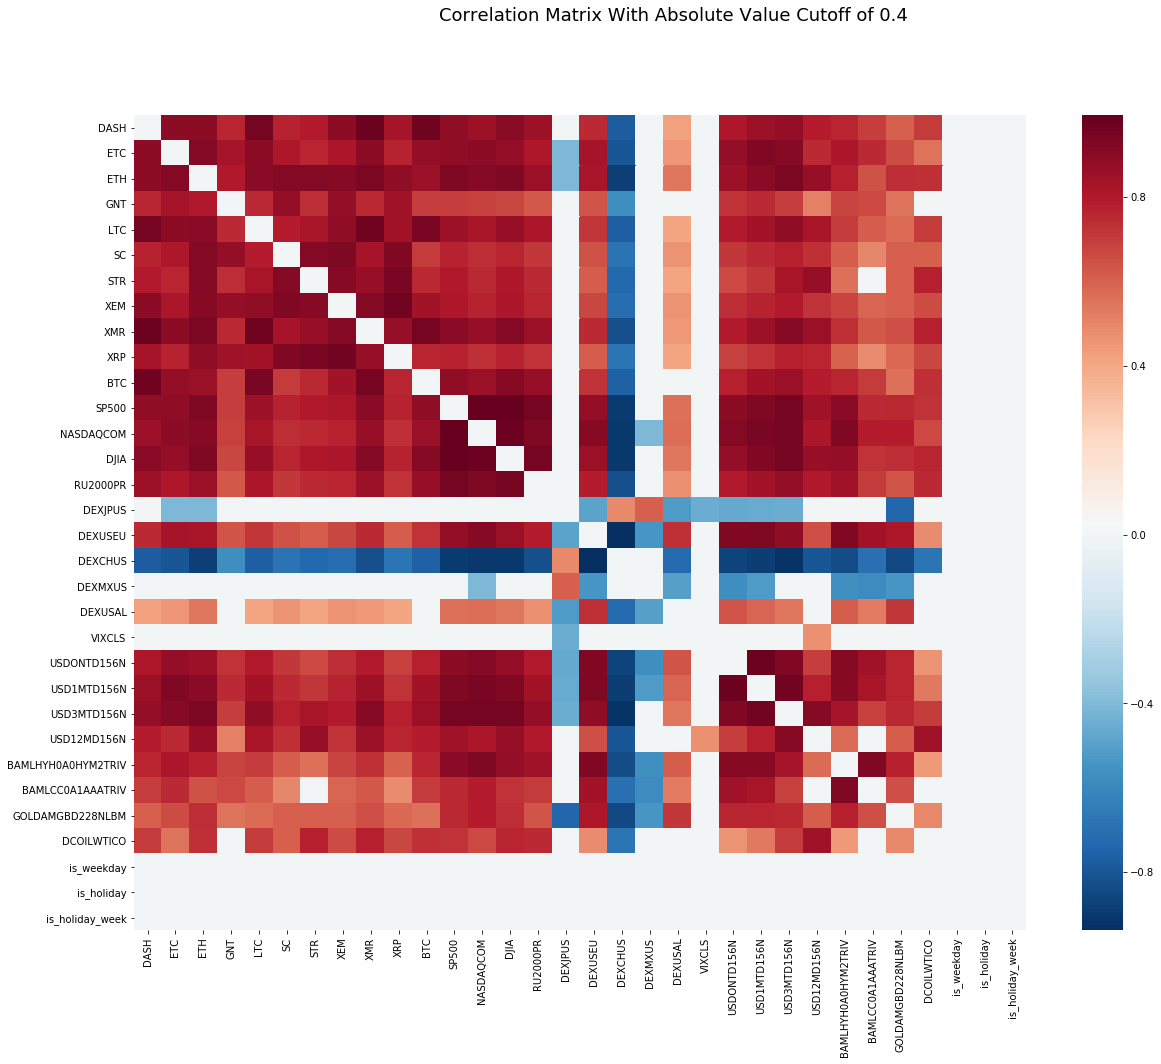

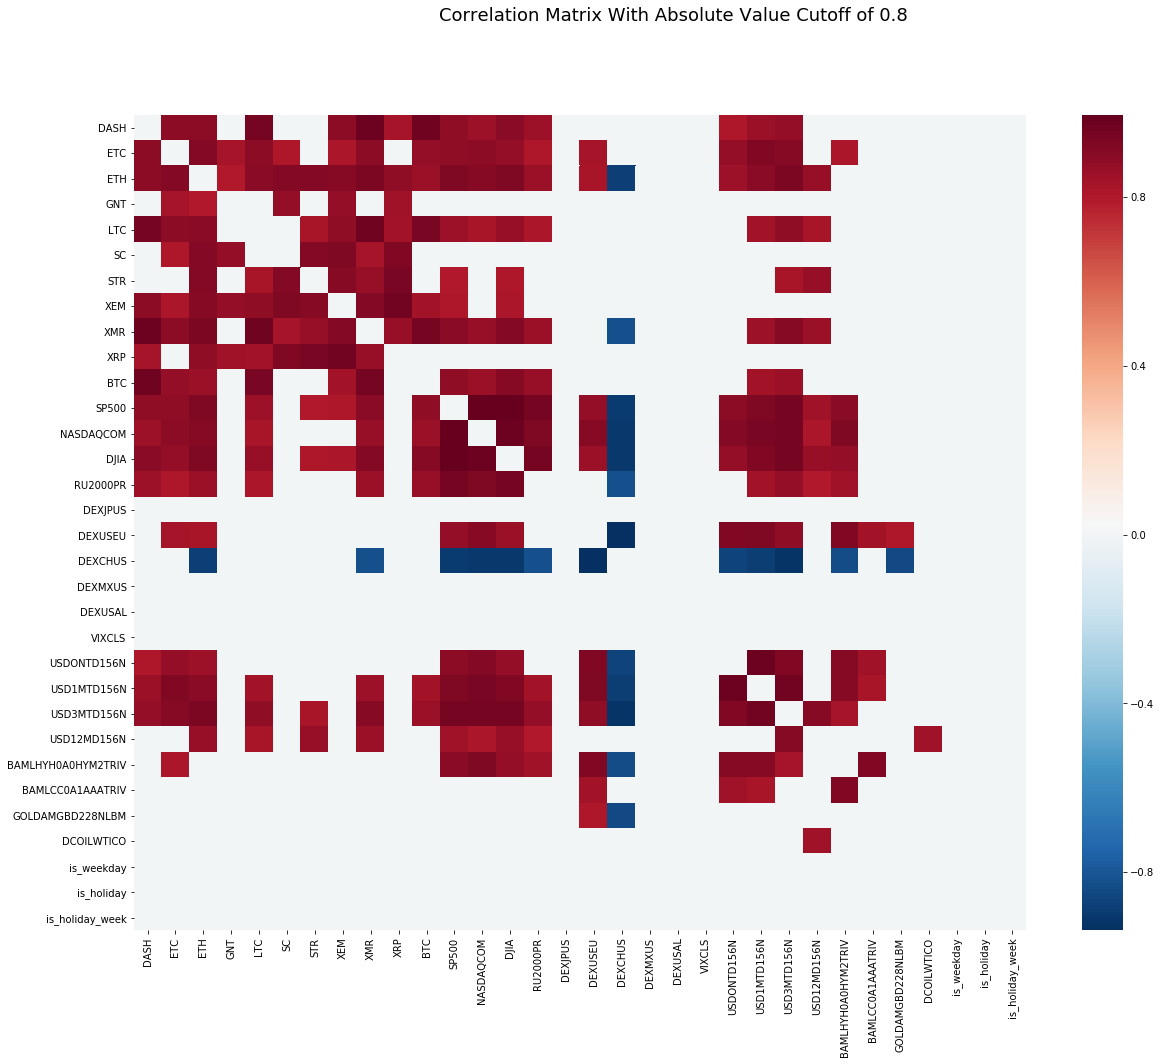

In [142]:
def correlation_heatmap(df, cutoff=None, title=''):
    df_corr = df.corr('pearson')
    np.fill_diagonal(df_corr.values, 0)
    if cutoff != None:
        for col in df_corr.columns:
            df_corr.loc[df_corr[col].abs() <= cutoff, col] = 0
    fig, ax = plt.subplots(figsize=(20, 15))
    sns.heatmap(df_corr, ax=ax, cmap='RdBu_r')
    plt.suptitle(title, size=18)
    plt.show()
    return df_corr


cutoffs = [.4, .8]
for cutoff in cutoffs:
    _ = correlation_heatmap(df_eda_scaled, cutoff, 'Correlation Matrix With Absolute Value Cutoff of {}'.format(cutoff))

### Heatmaps of Percent Changes in Original Data Using Correlation Matrices at Various Cutoffs

The same function used above is also used to explore the percent changes of the features in `tseries_cols`.  This is to get a feel for which series move together as a function of magnitude and time.

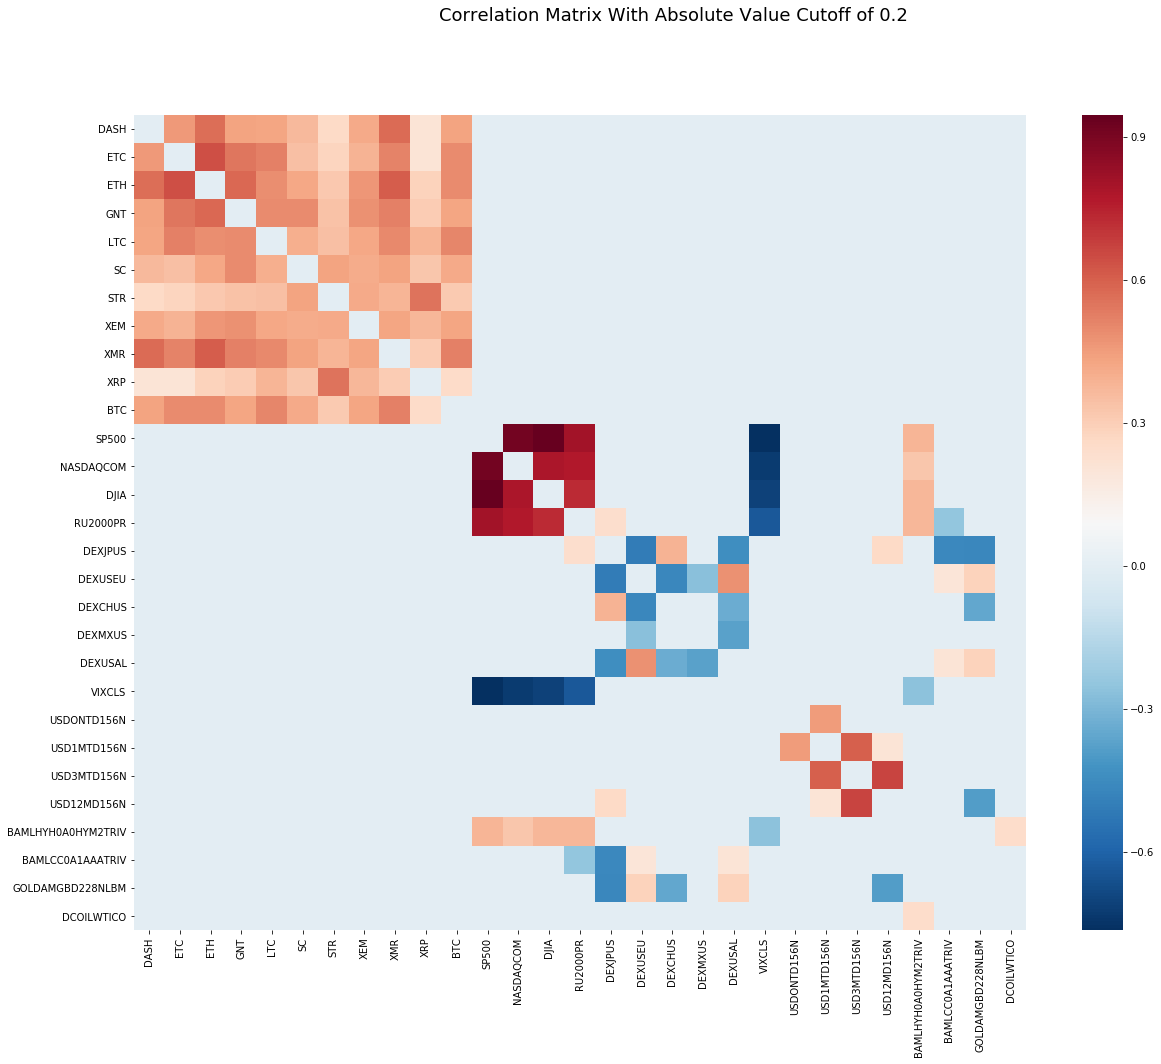

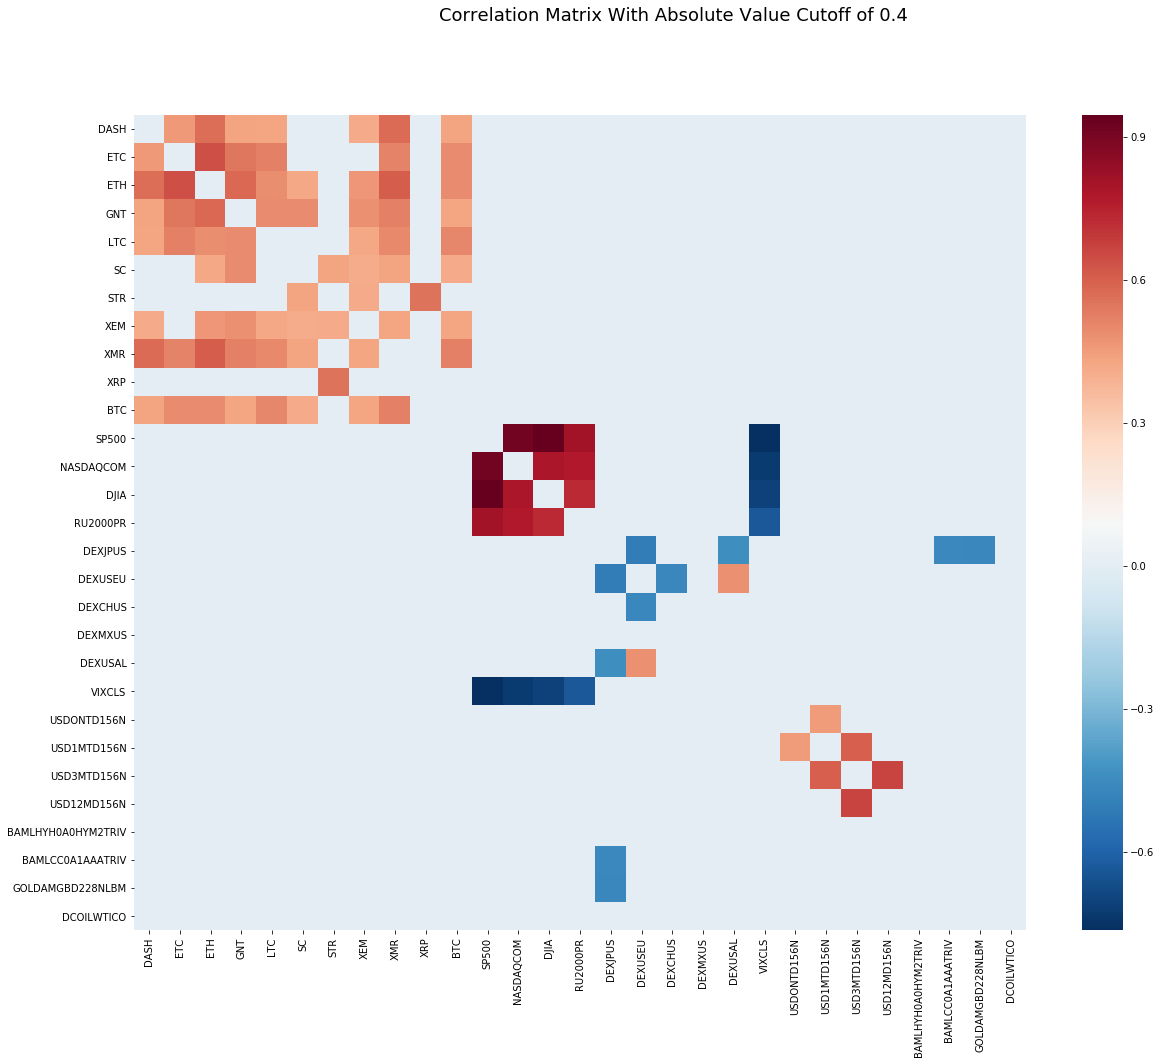

In [141]:
tseries_cols = non_norm_cols + norm_cols
df_eda_pct_change = df_eda[tseries_cols].pct_change()
cutoffs = [.2, .4]
for cutoff in cutoffs:
    _ = correlation_heatmap(df_eda_pct_change, cutoff, 'Correlation Matrix With Absolute Value Cutoff of {}'.format(cutoff))

Consistent with the literature we came across on the crypto-markets we observe that the various coins are strongly positively correlated with one another, both in their time-series form and in their percent-change form.  Perhaps also unsurprisingly we observe the same phenomena in the various equity markets (which also tend to move together through time).  

The correlations between the different debt markets are expected since the longer maturity instruments are a function of the shorter maturity contracts.  

It is also noteworthy that the `VIXCLS` percent change correlation has a strong negative correlation with all of the equity markets, reflecting the tumultuous couple years since the 2016 US election.  However the VIX does not show strong signal in the scaled data correlation matrix representation done first, shown by the fact that most of the VIX row/column is muted by the `cutoff` parameter.  The only un-muted cells are between the VIX and the USD-Yen (strong negative) and the VIX and the US 12 month rate.

# Revised Project Question

Given the messiness inherent in cryptocurrency markets, as well as all financial markets, we hope to simplify the analysis by reviewing both regression and classification techniques.  We hypothesize that a classification model will perform better than a regression model, and is likely to lead to better outcomes in a real-world scenario.  We also plan to simplify the world by taking the magnitude of investment out of any model that may be produced so that our recommendations are simply either **buy, sell or hold**.  

As of 4/19/2018 our working plan is the following:

- Decide on what our outcome variables will be for both regression and classification
- Set two baseline models: (1) Random Forest and (2) simply predicting the previouo day's value
- Test recurrent network flavor, either LSTM or GRU, to see if they have any efficacy whatsoever
- Update data for new outcome variables: whether the outcome (1) gained by X%, (2) fell by X%, or (3) did neither
- Train an autoencoder to extract features and reduce collinearity in the data
- Test deep feed forward network as a classification of the above new targets
- Methodically track hyperparameters in spreadsheet as we try them to explore hyperparameter space in a disciplined manner
- Backtest our best models and evaluate findings